Dans ce billet, nous allons extraire les données disponibles sur les scrutins de l'assemblée nationale afin de déterminer quels jours de la semaine sont propice au débat dans l'assemblée et quels jours ne le sont pas.

# Récupération des informations 

Les données qui m'intéressent sont sur la page suivante : [http://www2.assemblee-nationale.fr/scrutins/liste/%28legislature%29/14](http://www2.assemblee-nationale.fr/scrutins/liste/%28legislature%29/14).

Téléchargeons le contenu de cette page.

In [1]:
import requests

In [2]:
r = requests.get("http://www2.assemblee-nationale.fr/scrutins/liste/%28legislature%29/14")
r

<Response [200]>

Maintenant, passons la page dans le parser BeautifulSoup :

In [3]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.text, 'html.parser')

Les éléments qui nous intéressent sont les suivants : 

- numéro du scrutin
- date du scrutin
- objet du scrutin
- résultats : pour, contre, abstention volontaire

Ces éléments sont dans un grand tableau, que nous allons essayer d'extraire :

In [4]:
elems = soup.select('tbody tr')

In [5]:
len(elems)

100

Chaque élément précédent représente une ligne du tableau. La première ligne du tableau contient par exemple les informations suivantes :

In [6]:
elems[0]

<tr>
<td class="denom">1237*</td>
<td>10/02/2016</td>
<td class="desc">l'ensemble du projet de loi constitutionnelle de protection de la Nation (première lecture). [<a href="http://www.assemblee-nationale.fr/14/dossiers/protection_nation.asp">dossier</a>] [<a href="/scrutins/detail/(legislature)/14/(num)/1237">analyse du scrutin</a>]</td>
<td class="pour">317</td>
<td class="contre SSO">199</td>
<td class="abs SSO">51</td>
</tr>

Ecrivons une fonction qui extrait les informations d'une seule ligne.

In [7]:
def extract_information(line):
    """Extrait les informations d'une ligne du tableau des scrutins."""
    elems = line.find_all('td')
    # numéro de scrutin
    num = elems[0].text
    # date
    date = elems[1].text
    # objet
    obj = elems[2].text
    # pour
    pour = int(elems[3].text)
    # contre
    contre = int(elems[4].text)
    # abstention
    abstention = int(elems[5].text)
    return num, date, obj, pour, contre, abstention

On peut tester cette routine sur la première ligne :

In [8]:
extract_information(elems[0])

('1237*',
 '10/02/2016',
 "l'ensemble du projet de loi constitutionnelle de protection de la Nation (première lecture). [dossier] [analyse du scrutin]",
 317,
 199,
 51)

Répétons cette extraction pour chaque ligne :

In [9]:
data = [extract_information(line) for line in elems]

Comme on peut le voir, cela marche plutôt bien. Nous allons maintenant traiter ces informations avec `pandas`.

# Utilisation de pandas 

Nous pouvons directement importer les données précédentes dans un objet dataframe, qui va nous simplifier les démarches :

In [10]:
import pandas as pd

In [11]:
df = pd.DataFrame(data, columns=('numero', 'date', 'objet', 'pour', 'contre', 'abstention'))
df.head(10)

,numero,date,objet,pour,contre,abstention
0,1237*,10/02/2016,l'ensemble du projet de loi constitutionnelle ...,317,199,51
1,1236,09/02/2016,l'ensemble de l'article premier du projet de l...,116,19,11
2,1235,09/02/2016,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7
3,1234,09/02/2016,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7
4,1233,09/02/2016,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3
5,1232,09/02/2016,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2
6,1231,09/02/2016,l'article 2 du projet de loi constitutionnelle...,162,148,22
7,1230,09/02/2016,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25
8,1229,09/02/2016,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32
9,1228,09/02/2016,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41


A partir de ce tableau, nous pouvons calculer le nombre de d'absents, car il y a 577 députés à l'assemblée nationale.

In [144]:
df['presents'] = df['pour'] + df['contre'] + df['abstention']
df['absents'] = 577 - df.presents

In [13]:
df.head(10)

,numero,date,objet,pour,contre,abstention,absents
0,1237*,10/02/2016,l'ensemble du projet de loi constitutionnelle ...,317,199,51,10
1,1236,09/02/2016,l'ensemble de l'article premier du projet de l...,116,19,11,431
2,1235,09/02/2016,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,431
3,1234,09/02/2016,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,432
4,1233,09/02/2016,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3,416
5,1232,09/02/2016,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2,405
6,1231,09/02/2016,l'article 2 du projet de loi constitutionnelle...,162,148,22,245
7,1230,09/02/2016,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25,308
8,1229,09/02/2016,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32,294
9,1228,09/02/2016,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41,292


On peut représenter graphiquement les absences :

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

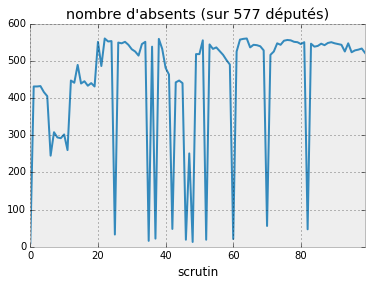

In [15]:
df.absents.plot()
plt.xlabel('scrutin')
plt.title("nombre d'absents (sur 577 députés)")

Afin de mieux appréhender cette distribution, regardons l'histogramme des absences :

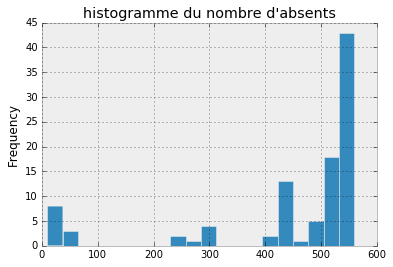

In [16]:
df.absents.plot(kind='hist', bins=20)
plt.title("histogramme du nombre d'absents")

On observe une distribution étrange : à gauche des scrutins avec peu d'absents (quelques uns), au milieu des scrutins à mi-assemblée (un peu moins) et beaucoup de scrutins avec beaucoup d'absents.

On peut s'intéresser aux dates des scrutins et rajouter l'information du jour de la semaine dans le tableau de données :

In [17]:
df.date = pd.to_datetime(df.date, dayfirst=True)

In [18]:
df.head(10)

,numero,date,objet,pour,contre,abstention,absents
0,1237*,2016-02-10,l'ensemble du projet de loi constitutionnelle ...,317,199,51,10
1,1236,2016-02-09,l'ensemble de l'article premier du projet de l...,116,19,11,431
2,1235,2016-02-09,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,431
3,1234,2016-02-09,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,432
4,1233,2016-02-09,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3,416
5,1232,2016-02-09,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2,405
6,1231,2016-02-09,l'article 2 du projet de loi constitutionnelle...,162,148,22,245
7,1230,2016-02-09,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25,308
8,1229,2016-02-09,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32,294
9,1228,2016-02-09,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41,292


Rajoutons le jour de la semaine à nos données :

In [33]:
day_mapping = {0: '01-lundi', 1: '02-mardi', 2: '03-mercredi', 
               3:'04-jeudi', 4: '05-vendredi', 5: '06-samedi', 6: '07-dimanche'}

In [34]:
df['jour'] = [day_mapping[date.dayofweek] for date in df.date]

In [35]:
df.head(10)

,numero,date,objet,pour,contre,abstention,absents,jour
0,1237*,2016-02-10,l'ensemble du projet de loi constitutionnelle ...,317,199,51,10,03-mercredi
1,1236,2016-02-09,l'ensemble de l'article premier du projet de l...,116,19,11,431,02-mardi
2,1235,2016-02-09,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,431,02-mardi
3,1234,2016-02-09,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,432,02-mardi
4,1233,2016-02-09,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3,416,02-mardi
5,1232,2016-02-09,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2,405,02-mardi
6,1231,2016-02-09,l'article 2 du projet de loi constitutionnelle...,162,148,22,245,02-mardi
7,1230,2016-02-09,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25,308,02-mardi
8,1229,2016-02-09,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32,294,02-mardi
9,1228,2016-02-09,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41,292,02-mardi


On peut donc désormais calculer des statistiques sur la base de cette information. Par exemple, regarder combien de scrutins ont eu lieu chaque jour de la semaine.

In [36]:
df.groupby('jour').size()

jour
01-lundi       10
02-mardi       38
03-mercredi    21
04-jeudi       21
05-vendredi    10
dtype: int64

On ne voit pas de scrutins le samedi ni le dimanche. Cela semble rassurant. Regardons la moyenne des absents sur ces jours :

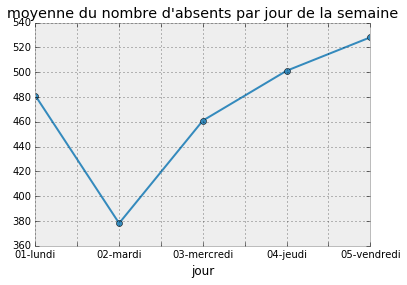

In [56]:
df.groupby('jour').mean()['absents'].plot(style='-o')
plt.title("moyenne du nombre d'absents par jour de la semaine")

On voit que le pic d'absents est le vendredi. Calculons le pourcentage d'absentéisme, c'est-à-dire divisons le nombre précédent par 577 députés.

(0, 100)

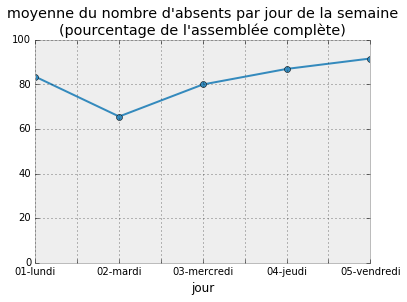

In [53]:
(df.groupby('jour').mean()['absents'] / 577 * 100).plot(style='-o')
plt.title("moyenne du nombre d'absents par jour de la semaine\n(pourcentage de l'assemblée complète)")
plt.ylim(0, 100)

Dans le graphique précédent, j'ai choisi de mettre l'échelle des ordonnées à 100% afin de montrer à quel point ces chiffres sont loins du 0% d'absents en moyenne.

Nous n'avons travaillé ici que sur des données partielles. Remontons dans le temps et téléchargeons toutes les données disponibles pour faire le travail ici présent.

# Récupération de tous les scrutins depuis 2012 

Pour faire ce travail, une simple boucle sur l'offset des scrutins permet de récupérer les données :

In [79]:
data = []
for offset in range(0, 1300, 100):
    url = "http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/{}/(legislature)/14/(type)/TOUS/(idDossier)/TOUS".format(offset)
    print(url)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    elems = soup.select('tbody tr')
    data += [extract_information(line) for line in elems]

http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/0/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/100/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/200/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/300/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/400/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/500/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/600/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/700/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee-nationale.fr/scrutins/liste/(offset)/800/(legislature)/14/(type)/TOUS/(idDossier)/TOUS
http://www2.assemblee

In [80]:
len(data)

1237

On a désormais accès à 1237 scrutins depuis juillet 2012, date de la dernière élection législative.

Construisons le tableau des données détaillées : 

In [158]:
df = pd.DataFrame(data, columns=('numero', 'date', 'objet', 'pour', 'contre', 'abstention'))

In [159]:
df['presents'] = df['pour'] + df['contre'] + df['abstention']
df['absents'] = 577 - df.presents
df.date = pd.to_datetime(df.date, dayfirst=True)
df['jour'] = [day_mapping[date.dayofweek] for date in df.date]

Un aperçu de la fin du tableau :

In [160]:
df.tail(10)

,numero,date,objet,pour,contre,abstention,presents,absents,jour
1227,10,2012-07-19,l'article 27 du projet de loi de finances rect...,106,52,0,158,419,04-jeudi
1228,9,2012-07-19,l'amendement n° 477 rect présenté par M. de C...,24,108,13,145,432,04-jeudi
1229,8,2012-07-19,le sous-amendement n° 547 présenté par M. Bor...,29,119,5,153,424,04-jeudi
1230,7,2012-07-19,sur l'article 4 du projet de loi de finances r...,44,17,3,64,513,04-jeudi
1231,6,2012-07-19,L'amendement n° 467 de M. de Courson à l'ar...,24,90,0,114,463,04-jeudi
1232,5,2012-07-18,l'article 2 du projet de loi de finances recti...,89,64,0,153,424,03-mercredi
1233,4,2012-07-18,les amendements de suppression de l'alinéa 2 à...,88,177,0,265,312,03-mercredi
1234,3,2012-07-18,les amendements de suppression de l'article 2 ...,81,178,1,260,317,03-mercredi
1235,2,2012-07-17,l'article 1er du projet de loi de finances rec...,61,48,1,110,467,02-mardi
1236,1,2012-07-03,la déclaration de politique générale du gouver...,302,225,17,544,33,02-mardi


Traçons l'histogramme du nombre de présents :

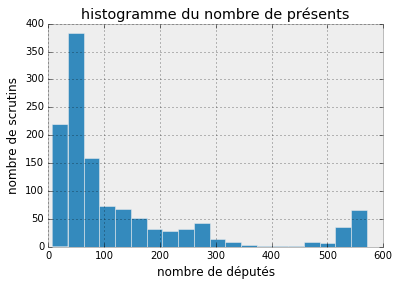

In [163]:
df.presents.plot(kind='hist', bins=20)
plt.title("histogramme du nombre de présents")
plt.xlabel("nombre de députés")
plt.ylabel("nombre de scrutins")

On voit que les députés sont absents, en moyenne, lors des scrutins avec une masse de scrutins avec faible présence, à gauche, et quelques scrutins avec beaucoup de députés.

Un histogramme cumulé permet d'interpréter plus facilement ces données :

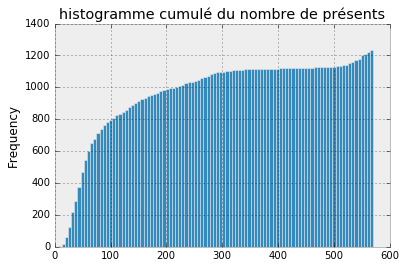

In [164]:
df.presents.plot(kind='hist', cumulative=True, bins=100)
plt.title("histogramme cumulé du nombre de présents")

Ce graphique permet de dire les choses suivants :

- il y a eu plus de 800 scrutins avec moins de 100 députés présents, depuis juillet 2012
- il y a eu plus de 1000 scrutins avec moins de 200 députés présents, depuis juillet 2012
- il y a une centainen de scrutins avec plus de 500 députés présents, depuis juillet 2012

In [165]:
df.presents.mean()

134.749393694422

En moyenne, sur les scrutins depuis juillet 2012, il y a avait 135 députés présents. Soit moins d'un quart de l'assemblée nationale.

On peut également répondre à la question : "quand les scrutins ont-ils lieu ?".

In [167]:
df.groupby('jour').size()

jour
01-lundi       181
02-mardi       280
03-mercredi    233
04-jeudi       295
05-vendredi    174
06-samedi       41
07-dimanche     33
dtype: int64

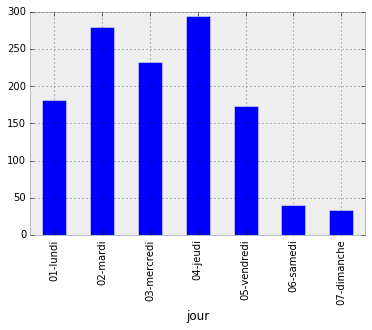

In [168]:
df.groupby('jour').size().plot(kind='bar')

Rien d'anormal : les scrutins ont lieu surtout les jours de la semaine, rarement le week-end. Pendant la semaine, ils ont lieu surtout le mardi et le jeudi.

Prochaine question : "quel jour de la semaine y a-t-il le plus d'absents lors des scrutins ?".

In [177]:
df.groupby('jour').mean()[['absents', 'presents']]

,absents,presents
jour,,
01-lundi,516.049724,60.950276
02-mardi,303.350000,273.650000
03-mercredi,438.141631,138.858369
04-jeudi,504.688136,72.311864
05-vendredi,517.235632,59.764368
06-samedi,394.829268,182.170732
07-dimanche,350.424242,226.575758


(0, 577)

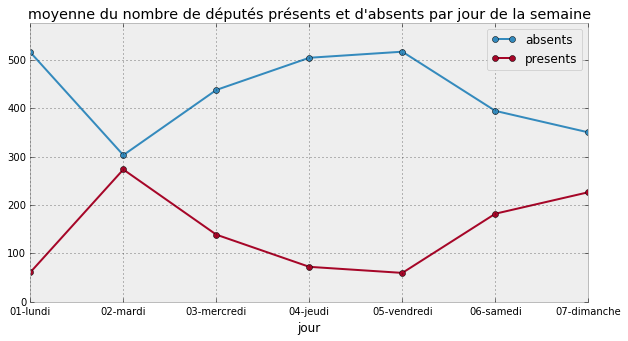

In [181]:
plt.subplots(figsize=(10, 5))
ax = plt.gca()
df.groupby('jour').mean()[['absents', 'presents']].plot(ax=ax, style='-o', legend=True)
plt.title("moyenne du nombre de députés présents et d'absents par jour de la semaine")
plt.ylim(0, 577)

On voit donc bien que les députés sont surtout absents lors des scrutins. En effet, en moyenne, on ne remplit jamais l'hémicycle.

On peut également représenter la courbe d'absentéisme en pourcentage :

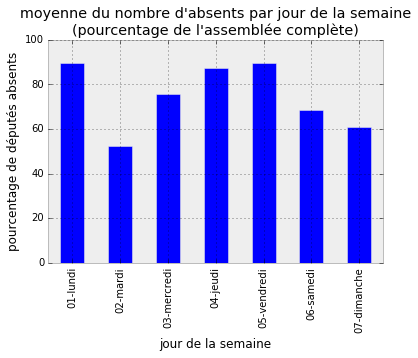

In [184]:
(df.groupby('jour').mean()['absents'] / 577 * 100).plot(kind='bar', style='-o')
plt.title("moyenne du nombre d'absents par jour de la semaine\n(pourcentage de l'assemblée complète)")
plt.ylim(0, 100)
plt.ylabel("pourcentage de députés absents")
plt.xlabel("jour de la semaine")

Nous avons donc répondu à la question principale qui se posait à nous : pour un scrutin moyen, combien de députés présents dans l'assemblée nationale. Penchons nous maintenant sur d'autres visualisations intéressantes.

# Quelques visualisations intéressantes 

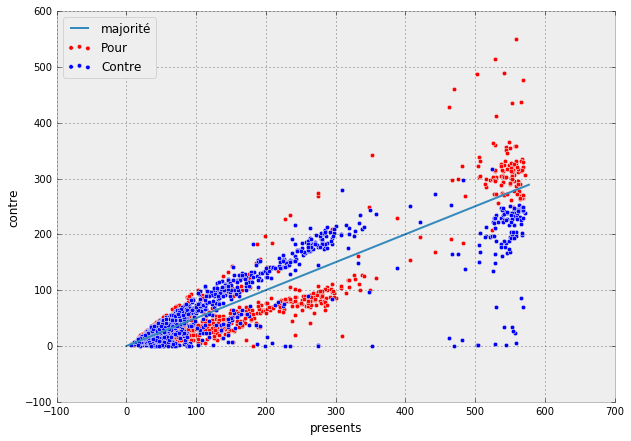

In [200]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot(ax=ax, kind='scatter', x='presents', y='pour', color='Red', label='Pour')
df.plot(ax=ax, kind='scatter', x='presents', y='contre', color='Blue', label='Contre')
plt.plot([0, 577], [0, 577//2+1], label='majorité')
plt.legend(loc='upper left')

In [107]:
df.columns

Index(['numero', 'date', 'objet', 'pour', 'contre', 'abstention', 'absents',
       'jour'],
      dtype='object')

In [111]:
df[df.absents < 10]

,numero,date,objet,pour,contre,abstention,absents,jour
282,955*,2014-11-18,l'ensemble du projet de loi de finances pour 2...,266,247,56,8,02-mardi
452,785,2014-04-08,la déclaration de politique générale du Gouver...,306,239,26,6,02-mardi
539,698*,2013-11-19,l'ensemble du projet de loi de finances pour 2...,320,242,6,9,02-mardi
559,678*,2013-10-29,l'ensemble du projet de loi de financement de ...,320,243,5,9,02-mardi
590,647*,2013-10-15,l'ensemble du projet de loi garantissant l'ave...,270,249,49,9,02-mardi
978,259*,2013-02-12,l'ensemble du projet de loi ouvrant le mariage...,329,229,10,9,02-mardi
1207,30*,2012-10-09,l'ensemble du projet de loi autorisant la rati...,477,70,21,9,02-mardi


(-1, 577)

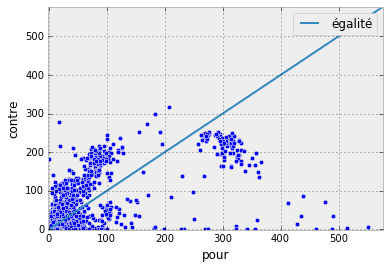

In [153]:
ax = plt.gca()
df.plot(ax=ax, kind='scatter', x='pour', y='contre')
plt.plot([0, 577], [0, 577], label="égalité")
plt.legend()
plt.xlim(-1, 577)
plt.ylim(-1, 577)

In [154]:
df[df.absents > 500].shape

(690, 9)

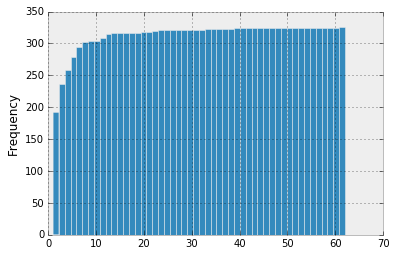

In [124]:
df.groupby('date').count()['numero'].plot(kind='hist', bins=50, cumulative=True)

In [143]:
(df.groupby('date').size() > 20).describe()

count          326
mean     0.0245399
std       0.154956
min          False
25%              0
50%              0
75%              0
max           True
dtype: object

In [131]:
df[df.date == '2016-02-09']

,numero,date,objet,pour,contre,abstention,absents,jour
1,1236,2016-02-09,l'ensemble de l'article premier du projet de l...,116,19,11,431,02-mardi
2,1235,2016-02-09,l'amendement n° 1 du Gouvernement à l'article ...,132,7,7,431,02-mardi
3,1234,2016-02-09,l'amendement n° 2 du Gouvernement à l'article ...,104,34,7,432,02-mardi
4,1233,2016-02-09,l'amendement n° 234 de M. Hamon après l'articl...,61,97,3,416,02-mardi
5,1232,2016-02-09,l'amendement n° 168 de M. Hamon après l'articl...,67,103,2,405,02-mardi
6,1231,2016-02-09,l'article 2 du projet de loi constitutionnelle...,162,148,22,245,02-mardi
7,1230,2016-02-09,le sous-amendement n° 271 de Mme Duflot et les...,59,185,25,308,02-mardi
8,1229,2016-02-09,le sous-amendement n° 250 de M. Goldberg et le...,77,174,32,294,02-mardi
9,1228,2016-02-09,l'amendement n° 50 de M. Schwartzenberg à l'ar...,64,180,41,292,02-mardi
10,1227,2016-02-09,l'amendement n° 207 de M. Faure à l'article 2 ...,108,145,22,302,02-mardi


In [157]:
df[df.presents > 550]

,numero,date,objet,pour,contre,abstention,absents,jour,presents
0,1237*,2016-02-10,l'ensemble du projet de loi constitutionnelle ...,317,199,51,10,03-mercredi,567
35,1202*,2015-12-08,l'ensemble du projet de loi de finances rectif...,296,246,19,16,02-mardi,561
37,1200*,2015-12-01,l'ensemble du projet de loi de modernisation d...,296,243,16,22,02-mardi,555
46,1191*,2015-11-19,l'ensemble du projet de loi prorogeant l'appli...,551,6,1,19,04-jeudi,558
48,1189*,2015-11-17,l'ensemble du projet de loi de finances pour 2...,290,244,30,13,02-mardi,564
52,1185*,2015-10-27,l'ensemble du projet de loi de financement de ...,286,245,27,19,02-mardi,558
60,1177*,2015-10-20,le projet de loi de finances pour 2016 (premiè...,277,247,32,21,02-mardi,556
110,1127*,2015-06-02,l'ensemble du projet de loi relatif au dialogu...,301,238,13,25,02-mardi,552
117,1120*,2015-05-26,l'ensemble du projet de loi relatif à la trans...,308,217,31,21,02-mardi,556
128,1109*,2015-05-05,l'ensemble du projet de loi relatif au renseig...,438,86,42,11,02-mardi,566
